In [ ]:
#default_exp constants.isotope

In [ ]:
#export
import numba
import numpy as np
import typing

from alphabase.constants.element import (
    MAX_ISOTOPE_LEN, EMPTY_DIST,
    CHEM_ISOTOPE_DIST, CHEM_MONO_IDX, CHEM_MONO_MASS,
    truncate_isotope, parse_formula
)

# Isotope distribution (in centroid mode)


If we have two isotope distributions, we can use convolute them into one distribution by using `abundance_convolution`.

In [ ]:
#export
@numba.njit
def abundance_convolution(
    d1:np.array,
    mono1:int,
    d2:np.array,
    mono2:int,
)->typing.Tuple[np.array, int]:
    '''
    If we have two isotope distributions, 
    we can convolute them into one distribution. 
    
    Args:
        d1 (np.array): isotope distribution to convolute.
        mono1 (int): mono position of d1.
        d2 (np.array): isotope distribution to convolute.
        mono2 (int): mono position of d2
    Returns:
        np.array: convoluted isotope distribution.
        int: new mono position.
    '''
    mono_idx = mono1 + mono2
    ret = np.zeros(MAX_ISOTOPE_LEN*2-1)
    for i in range(len(d1)):
        for j in range(len(d2)):
            ret[i+j] += d1[i]*d2[j]

    mono_idx, start, end = truncate_isotope(ret, mono_idx)
    return ret[start:end], mono_idx

For a given chemical formula, e.g. `H(100)O(50)N(20)`, we first calculate the isotope distribution using "binary search"-like method for each type of element (here are `H(100)`, `O(50)` and `N(20)`) (see `one_element_dist()`). And then we convolute these distributions of all types into one distribution (see `formula_dist()`).

In [ ]:
#export
@numba.njit
def one_element_dist(
    elem: str,
    n: int,
    chem_isotope_dist: numba.typed.Dict,
    chem_mono_idx: numba.typed.Dict,
)->typing.Tuple[np.array, int]:
    '''
    Calculate the isotope distribution for 
    an element and its numbers.
    
    Args:
        elem (str): element.
        n (int): element number.
        chem_isotope_dist (numba.typed.Dict): use `CHEM_ISOTOPE_DIST` as parameter.
        chem_mono_idx (numba.typed.Dict): use `CHEM_MONO_IDX` as parameter.
    Returns:
        np.array: isotope distribution of the element.
        int: mono position in the distribution
    '''
    if n == 0: return EMPTY_DIST.copy(), 0
    elif n == 1: return chem_isotope_dist[elem], chem_mono_idx[elem]
    tmp_dist, mono_idx = one_element_dist(elem, n//2, chem_isotope_dist, chem_mono_idx)
    tmp_dist, mono_idx = abundance_convolution(tmp_dist, mono_idx, tmp_dist, mono_idx)
    if n%2 == 0:
        return tmp_dist, mono_idx
    else:
        return abundance_convolution(tmp_dist, mono_idx, chem_isotope_dist[elem], chem_mono_idx[elem])

def formula_dist(
    formula: typing.Union[list, str]
)->typing.Tuple[np.array, int]:
    '''
    Generate the isotope distribution and the mono index for 
    a given formula (as a list, e.g. `[('H', 2), ('C', 2), ('O', 1)]`),
    Args:
        formula (typing.Union[list, str]): chemical formula, could be str or list.
            If str: "H(1)N(2)O(3)".
            If list: "[('H',1),('H',2),('H',3)]".
    Returns:
        np.array: isotope distribution
        int: mono position
    '''
    if isinstance(formula, str):
        formula = parse_formula(formula)
    calc_dist = EMPTY_DIST.copy()
    mono_idx = 0
    for elem, n in formula:
        _dist, _mono = one_element_dist(elem, n, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
        calc_dist, mono_idx = abundance_convolution(calc_dist, mono_idx, _dist, _mono)
    return calc_dist, mono_idx

Compare calculated isotope distributions with sisweb.com/mstools/isotope.htm

Desired distribution for H10: (100, 0.16, 0.0001) calculated from sisweb.com/mstools/isotope.htm in low resolution mode (centroid mode)

In [ ]:
#hide
dist, mono_idx = one_element_dist('H', 10, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
assert mono_idx == 0
[f'{d*100:.4f}' for d in dist/max(dist)]


['100.0000',
 '0.1150',
 '0.0001',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000',
 '0.0000']

In [ ]:
#hide
formula = 'C(100)H(100)O(10)'
formula = parse_formula(formula)
expected = [('C', 100), ('H', 100), ('O', 10)]
for exp_val, val in zip(expected, formula):
    assert exp_val == val

In [ ]:
#hide
mass = np.sum([CHEM_MONO_MASS[elem]*n for elem,n in formula])
assert abs(mass-1460.73164942)<1e-6

['91.1674',
 '100.0000',
 '56.1843',
 '21.5256',
 '6.3163',
 '1.5117',
 '0.3069',
 '0.0543',
 '0.0085',
 '0.0012']

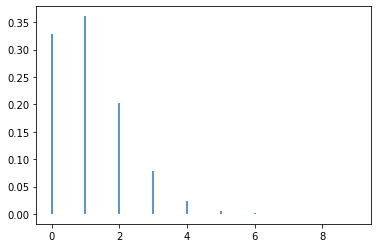

In [ ]:
#hide
try:
    import matplotlib.pyplot as plt
except:
    plt = None
calc_dist, mono_idx = formula_dist(formula)
assert mono_idx==0

if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]


Desired distribution for `C(100)H(100)O(10)`: `(90.7784, 100, 56.368, 21.6475, 6.3624, 1.524, 0.3093)` calculated from sisweb.com/mstools/isotope.htm in low resolution mode (centroid mode)

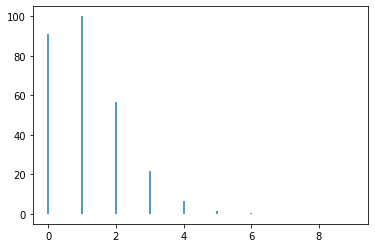

In [ ]:
#hide
target_dist = np.zeros(MAX_ISOTOPE_LEN)

target_dist[:7] = [90.7784, 100, 56.368, 21.6475, 6.3624, 1.524, 0.3093]
if plt: plt.vlines(np.arange(len(target_dist)), ymin=np.zeros_like(target_dist), ymax=target_dist)

### The target and calculated distributions are very similar

In [ ]:
#hide
cosine = np.sum(calc_dist*target_dist)/np.sum(np.sqrt(calc_dist**2 * target_dist**2))
cosine

1.0000000000000004

### Compare with Averagine

In [ ]:
#hide
averagine_aa = {}
averagine_aa["C"] = 4.9384
averagine_aa["H"] = 7.7583
averagine_aa["N"] = 1.3577
averagine_aa["O"] = 1.4773
averagine_aa["S"] = 0.0417
averagine_avg = 111.1254

nAA = int(mass/averagine_avg)
nH = int(mass - nAA*averagine_avg)
nAA, nH

(13, 16)

['100.0000',
 '77.4892',
 '33.5415',
 '10.4826',
 '2.6175',
 '0.5509',
 '0.1010',
 '0.0165',
 '0.0024',
 '0.0003']

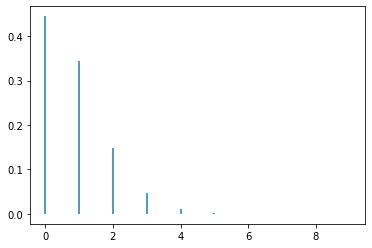

In [ ]:
#hide
if nH:
    calc_dist, mono_idx = one_element_dist('H', nH, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
else:
    calc_dist = EMPTY_DIST.copy()
    mono_idx = 0
for elem, num in averagine_aa.items():
    n = int(nAA*num)
    _dist, _mono = one_element_dist(elem, n, CHEM_ISOTOPE_DIST, CHEM_MONO_IDX)
    calc_dist, mono_idx = abundance_convolution(calc_dist, mono_idx, _dist, _mono)
if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]

Test for heavy labeled formula

['0.9157',
 '91.6573',
 '100.0000',
 '56.0834',
 '21.4676',
 '6.2959',
 '1.5062',
 '0.3057',
 '0.0540',
 '0.0085']

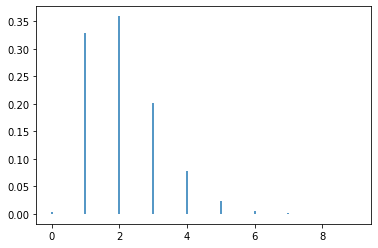

In [ ]:
#hide
formula = 'C(100)H(100)O(10)13C(1)'

calc_dist, mono_idx = formula_dist(formula)
assert mono_idx == 1
assert np.argmax(calc_dist)==2

if plt: plt.vlines(np.arange(len(calc_dist)), ymin=np.zeros_like(calc_dist), ymax=calc_dist)
[f'{d*100:.4f}' for d in calc_dist/max(calc_dist)]

# IsotopeDistribution
`formula_dist()` always calculates the distribution of each element based on the element number (using binary-search-like operation) and convolute distributions of different elements. If we have many peptides to calculate, each element's distribution will be calculated repeatly. In `IsotopeDistribution`, instead of generating on-the-fly, we pre-built the isotope distribution table for each of the most common elements (C,H,N,O,S,P) with the element number from 0 to N, and N is large enough to cover all composition in shotgun proteomics. Thus, for a given chemical formula, we just need to check the distribution table for each element and convolute distributions among different elements.

In [ ]:
#export

def _calc_one_elem_cum_dist(
    element_cum_dist:np.array, 
    element_cum_mono:np.array
):
    """Pre-build isotope abundance distribution for an element for fast calculation.
    Internel function.

    Args:
        element_cum_dist (np.array): cumulated element abundance distribution
        element_cum_mono (np.array): cumulated element mono position in the distribution
    Returns:
        None. Added information inplace into element_cum_dist and element_cum_mono
    """
    for n in range(2, len(element_cum_dist)):
        (
            element_cum_dist[n], 
            element_cum_mono[n]
        ) = abundance_convolution(
            element_cum_dist[n-1],
            element_cum_mono[n-1],
            element_cum_dist[1],
            element_cum_mono[1]
        )

class IsotopeDistribution:
    def __init__(self, 
        max_elem_num_dict:dict = {
            'C': 2000,
            'H': 5000,
            'N': 1000,
            'O': 1000,
            'S': 200,
            'P': 200,
        }
    ):
        """Faster calculation of isotope abundance distribution by pre-building
        isotope distribution tables for most common elements.

        Args:
            max_elem_num_dict (dict, optional): 
                Define the maximal number of the elements. 
                Defaults to { 'C': 2000, 'H': 5000, 'N': 1000, 'O': 1000, 'S': 200, 'P': 200, } 
            
                We have considered large enough number of elements for shotgun proteomics.
                We can increase `max_elem_num_dict` to support larger peptide or top-down 
                in the future. However, current `MAX_ISOTOPE_LEN` is not suitable for top-down,
                it must be extended to a larger number (100?).
                Note that non-standard amino acids have 1000000 C elements in AlphaBase,
                We clip 1000000 C to the maximal number of C in `max_elem_num_dict`.
                As they have very large masses thus impossible to identify,
                their isotope distributions do not matter.
        Attributes:
            element_to_cum_dist_dict (dict): 
                {element: cumulated isotope distribution array},
                and the cumulated isotope distribution array is a 2-D float np.array with 
                shape (element_max_number, MAX_ISOTOPE_LEN).
            element_to_cum_mono_idx (dict): 
                {element: mono position array of cumulated isotope distribution},
                and mono position array is a 1-D int np.array.
        """
        self.element_to_cum_dist_dict = {}
        self.element_to_cum_mono_idx = {}
        for elem, n in max_elem_num_dict.items():
            if n < 2: n = 2
            self.element_to_cum_dist_dict[elem] = np.zeros((n, MAX_ISOTOPE_LEN))
            self.element_to_cum_mono_idx[elem] = -np.ones(n,dtype=np.int64)
            self.element_to_cum_dist_dict[elem][0,:] = EMPTY_DIST
            self.element_to_cum_mono_idx[elem][0] = 0
            self.element_to_cum_dist_dict[elem][1,:] = CHEM_ISOTOPE_DIST[elem]
            self.element_to_cum_mono_idx[elem][1] = CHEM_MONO_IDX[elem]
            _calc_one_elem_cum_dist(
                self.element_to_cum_dist_dict[elem],
                self.element_to_cum_mono_idx[elem]
            )

    def calc_formula_distribution(self,
        formula: typing.List[typing.Tuple[str,int]],
    )->typing.Tuple[np.array, int]:
        """Calculate isotope abundance distribution for a given formula

        Args:
            formula (list of tuple(str,int)): 
                chemical formula: "[('H',1),('C',2),('O',3)]".

        Returns:
            np.array: 
                isotope abundance distribution
            int: mono 
                isotope position in the distribution array
        
        Examples::
        
            >>> from alphabase.constants import IsotopeDistribution, parse_formula
            >>> iso = IsotopeDistribution()
            >>> formula = 'C(100)H(100)O(10)Na(1)Fe(1)'
            >>> formula = parse_formula(formula)
            >>> dist, mono = iso.calc_formula_distribution(formula)
            >>> dist
            array([1.92320044e-02, 2.10952666e-02, 3.13753566e-01, 3.42663681e-01,
                   1.95962632e-01, 7.69157517e-02, 2.31993814e-02, 5.71948249e-03,
                   1.19790438e-03, 2.18815385e-04])
            >>> # Fe's mono position is 2 Da larger than its smallest mass, 
            >>> # so the mono position of this formula shifts by +2 (Da).
            >>> mono 
            2

            >>> formula = 'C(100)H(100)O(10)13C(1)Na(1)' 
            >>> formula = parse_formula(formula)
            >>> dist, mono = iso.calc_formula_distribution(formula)
            >>> dist
            array([3.29033438e-03, 3.29352217e-01, 3.59329960e-01, 2.01524592e-01,
                   7.71395498e-02, 2.26229845e-02, 5.41229894e-03, 1.09842389e-03,
                   1.94206388e-04, 3.04911585e-05])
            >>> # 13C's mono position is +1 Da shifted
            >>> mono
            1

            >>> formula = 'C(100)H(100)O(10)Na(1)' 
            >>> formula = parse_formula(formula)
            >>> dist, mono = iso.calc_formula_distribution(formula)
            >>> dist
            array([3.29033438e-01, 3.60911319e-01, 2.02775462e-01, 7.76884706e-02,
                   2.27963906e-02, 5.45578135e-03, 1.10754072e-03, 1.95857410e-04,
                   3.07552058e-05, 4.35047710e-06])
            >>> # mono position is normal (=0) for regular formulas
            >>> mono
            0
            
        """
        first_elem = 'H'
        for elem, n in formula:
            if elem == first_elem:
                if n >= len(self.element_to_cum_mono_idx[elem]):
                    n = len(self.element_to_cum_mono_idx[elem])-1
                mono = self.element_to_cum_mono_idx[elem][n]
                dist = self.element_to_cum_dist_dict[elem][n]
                break
        for elem, n in formula:
            if elem in self.element_to_cum_dist_dict:
                if elem == first_elem: continue
                if n >= len(self.element_to_cum_mono_idx[elem]):
                    n = len(self.element_to_cum_mono_idx[elem])-1
                dist, mono = abundance_convolution(
                    dist, mono,
                    self.element_to_cum_dist_dict[elem][n],
                    self.element_to_cum_mono_idx[elem][n],
                )
            else:
                dist, mono = abundance_convolution(
                    dist, mono, *one_element_dist(
                        elem,n,CHEM_ISOTOPE_DIST, CHEM_MONO_IDX
                    )
                )
        return dist, mono
        


In [ ]:
#hide
iso = IsotopeDistribution()
formula = 'C(100)H(100)O(10)Na(1)Fe(1)'
formula = parse_formula(formula)
dist, mono = iso.calc_formula_distribution(formula)
dist1, mono1 = formula_dist(formula)
assert np.allclose(dist, dist1)
assert mono==mono1
assert mono==2

In [ ]:
dist

array([1.92320044e-02, 2.10952666e-02, 3.13753566e-01, 3.42663681e-01,
       1.95962632e-01, 7.69157517e-02, 2.31993814e-02, 5.71948249e-03,
       1.19790438e-03, 2.18815385e-04])

In [ ]:
#hide
iso = IsotopeDistribution()
formula = 'C(100)H(100)O(10)13C(1)Na(1)'
formula = parse_formula(formula)
dist, mono = iso.calc_formula_distribution(formula)
dist1, mono1 = formula_dist(formula)
assert np.allclose(dist, dist1)
assert mono==mono1
assert mono==1

In [ ]:
iso = IsotopeDistribution()
formula = 'C(100)H(100)O(10)Na(1)'
formula = parse_formula(formula)
dist, mono = iso.calc_formula_distribution(formula)
dist1, mono1 = formula_dist(formula)
assert np.allclose(dist, dist1)
assert mono==mono1
assert mono==0